In [1]:
import os
import wfdb
import scipy
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from tqdm import tqdm

In [2]:
def resample_sig(x, fs, fs_target):
    t = np.arange(x.shape[0]).astype("float64")

    if fs == fs_target:
        return x, t

    new_length = int(x.shape[0] * fs_target / fs)
    # Resample the array if NaN values are present
    if np.isnan(x).any():
        x = pd.Series(x.reshape((-1,))).interpolate().values
    resampled_x, resampled_t = scipy.signal.resample(x, num=new_length, t=t)
    assert (
        resampled_x.shape == resampled_t.shape
        and resampled_x.shape[0] == new_length
    )
    assert np.all(np.diff(resampled_t) > 0)

    return resampled_x, resampled_t

In [59]:
def preprocess(init_address, final_address, length=7500):
    files = [file[:-4] for file in os.listdir(init_address) if file.endswith('.dat')]

    classes = {'W': 0, '1': 1, '2': 2, '3': 3, '4': 3, 'R': 4}

    data = []
    for file in tqdm(files):
        signal = wfdb.rdrecord(init_address + file, channels=[0]).p_signal
        segments = wfdb.rdann(init_address + file, extension='st').sample
        stages = wfdb.rdann(init_address + file, extension='st').aux_note
        
        for idx, start in enumerate(segments):
            if start == 1:
                start = 0
            else:
                pass
            
            if stages[idx][0] != 'M':
                resampled_x, _ = resample_sig(signal[start:start+length, 0], 250, 100)
                data.append(np.append(resampled_x, classes[stages[idx][0]]))

    df = pd.DataFrame(np.array(data))
    df.to_csv(final_address)
    
    print(f"\nThe data has been saved in {final_address}.")
    
preprocess('../../Dataset/Sleep/', '../dataset/dataset.csv' ,length=7500)

100%|██████████| 18/18 [00:11<00:00,  1.62it/s]



The data has been saved in ../dataset/dataset.csv.


In [8]:
df = pd.read_csv('../dataset/dataset.csv')
df = df.drop(['Unnamed: 0'], axis=1)

labels = [int(i) for i in list(df['3000'])]

print(f"Number od signals with the label 0 is: {labels.count(0)}")
print(f"Number od signals with the label 1 is: {labels.count(1)}")
print(f"Number od signals with the label 2 is: {labels.count(2)}")
print(f"Number od signals with the label 3 is: {labels.count(3)}")
print(f"Number od signals with the label 4 is: {labels.count(4)}")

Number od signals with the label 0 is: 3115
Number od signals with the label 1 is: 1815
Number od signals with the label 2 is: 3887
Number od signals with the label 3 is: 664
Number od signals with the label 4 is: 700


In [7]:
df.shape

(10181, 3001)

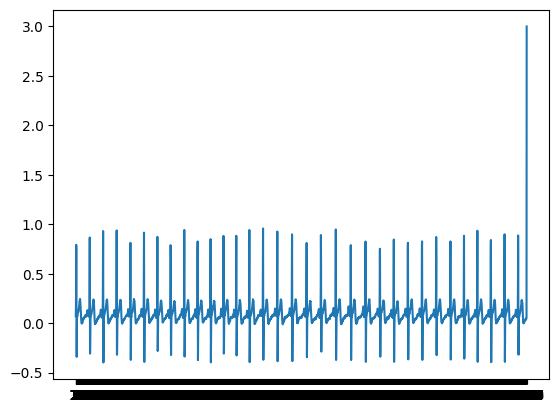

In [9]:
plt.plot(df.iloc[0])

In [6]:
train = df.iloc[:int(len(df) * 0.8), :]

In [6]:
train.shape

(8144, 3001)

In [11]:
np.array(train.iloc[0][:3000])

array([0.0711013 , 0.14623332, 0.3313848 , ..., 0.04879917, 0.04797405,
       0.06416583])

In [29]:
from ssqueezepy import ssq_stft

Twxo, TF, *_ = ssq_stft(np.array(train.iloc[0][:512]))

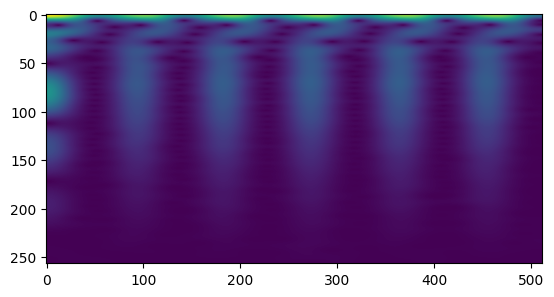

In [30]:
plt.imshow(np.abs(TF))

In [31]:
np.abs(TF).min()

9.6721575e-05

In [4]:
import os

os.chdir('../')

In [7]:
from dataloader.dataloader import DataGenerator

my_generator = DataGenerator(data=train, 
                             image_shape=(256, 512, 1), 
                             signal_shape=(3000, 1), 
                             batch_size=4, 
                             cls_num=5, 
                             width=512, 
                             overlap=17)

In [9]:
a = next(iter(my_generator))

In [16]:
print(a[0][0][0].shape)
print(a[0][0][0].max())
print(a[0][0][0].min())

(6, 256, 512, 1)
1.0
0.0


In [17]:
print(a[0][1][0].shape)
print(a[0][1][0].max())
print(a[0][1][0].min())

(3000, 1)
1.0
0.0


In [19]:
print(a[1])

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [1]:
import os

os.chdir('../')

In [2]:
from model.model import build

model = build(image_shape=(6, 256, 512, 1), 
              signal_shape=(3000, 1), 
              num_classes=5, 
              lnn_units=[512, 128], 
              fin_path='checkpoints/fin_20240810_050955', 
              kan_units=[32])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 256, 512  0           []                               
                                , 1)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 6, 64, 128,   0          ['input_1[0][0]']                
 ted)                           1)                                                                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 6, 64, 128,   80         ['time_distributed[0][0]']       
 buted)                         8)                                                          

In [5]:
def generate_ecg_waveform(length, heart_rate=60, sampling_rate=100):
    """
    Generate a synthetic ECG-like waveform of a specified length.
    
    Parameters:
    - length: The number of samples in the ECG signal.
    - heart_rate: The heart rate in beats per minute.
    - sampling_rate: The sampling rate in Hz (samples per second).
    
    Returns:
    - ecg_signal: A synthetic ECG signal as a numpy array.
    """
    # Time vector
    t = np.linspace(0, length/sampling_rate, length)

    # Heartbeat period in seconds
    heartbeat_period = 60.0 / heart_rate
    
    # Create an empty signal
    ecg_signal = np.zeros_like(t)
    
    # Number of heartbeats in the signal
    num_heartbeats = int(length / (heartbeat_period * sampling_rate))
    
    for i in range(num_heartbeats):
        # Time offset for each heartbeat
        time_offset = i * heartbeat_period
        
        # P-wave (small upward deflection)
        p_wave = 0.1 * np.exp(-((t - time_offset - 0.2) ** 2) / 0.01)
        
        # QRS complex (sharp spike)
        q_wave = -0.15 * np.exp(-((t - time_offset - 0.25) ** 2) / 0.001)
        r_wave = 1.0 * np.exp(-((t - time_offset - 0.3) ** 2) / 0.002)
        s_wave = -0.2 * np.exp(-((t - time_offset - 0.35) ** 2) / 0.001)
        
        # T-wave (broader upward deflection)
        t_wave = 0.3 * np.exp(-((t - time_offset - 0.45) ** 2) / 0.015)
        
        # Combine the waves to form the ECG signal
        ecg_signal += p_wave + q_wave + r_wave + s_wave + t_wave
    
    return ecg_signal

def generate_data(data_num, data_length):
    """
    Generate a DataFrame of synthetic ECG-like waveforms.
    
    Parameters:
    - data_num: The number of ECG signals to generate (rows).
    - data_length: The length of each ECG signal (columns).
    
    Returns:
    - df: A pandas DataFrame containing the synthetic ECG signals.
    """
    ecg_signals = [generate_ecg_waveform(data_length) for _ in range(data_num)]
    df = pd.DataFrame(ecg_signals)
    return df

In [6]:
df = generate_data(2, 3000)

df

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.001832,0.002706,0.003919,0.005562,0.007738,0.010552,0.014106,0.018483,0.023741,0.029893,...,2.246328e-07,1.208195e-07,6.412196e-08,3.358009e-08,1.735252e-08,8.848076e-09,4.451851e-09,2.210232e-09,1.082781e-09,5.234187e-10
1,0.001832,0.002706,0.003919,0.005562,0.007738,0.010552,0.014106,0.018483,0.023741,0.029893,...,2.246328e-07,1.208195e-07,6.412196e-08,3.358009e-08,1.735252e-08,8.848076e-09,4.451851e-09,2.210232e-09,1.082781e-09,5.234187e-10


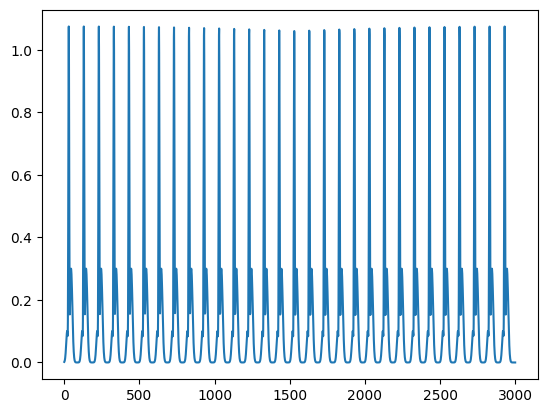

In [7]:
plt.plot(df.iloc[0])

In [2]:
import pandas as pd

df = pd.read_csv('../dataset/synthetic.csv')

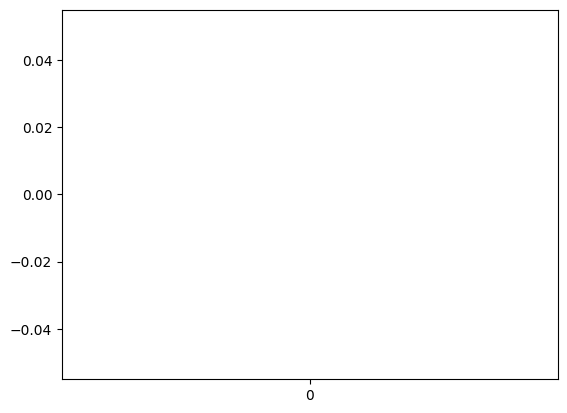

In [8]:
import matplotlib.pyplot as plt

plt.plot(df.iloc[0])
plt.show()

In [19]:
import numpy as np

def generate_random_ecg_waveform(length, sampling_rate=100):
    """
    Generate a synthetic ECG-like waveform with randomness in the amplitude, timing, and width,
    and with a random heart rate between 60 and 90 beats per minute.
    
    Parameters:
    - length: The number of samples in the ECG signal.
    - sampling_rate: The sampling rate in Hz (samples per second).
    
    Returns:
    - ecg_signal: A synthetic ECG signal as a numpy array.
    """
    # Random heart rate between 60 and 90 bpm
    heart_rate = np.random.randint(60, 91)
    
    # Time vector
    t = np.linspace(0, length/sampling_rate, length)

    # Heartbeat period in seconds
    heartbeat_period = 60.0 / heart_rate
    
    # Create an empty signal
    ecg_signal = np.zeros_like(t)
    
    # Number of heartbeats in the signal
    num_heartbeats = int(length / (heartbeat_period * sampling_rate))
    
    for i in range(num_heartbeats):
        # Time offset for each heartbeat
        time_offset = i * heartbeat_period
        
        # Random variations in the waveform parameters with clamping for stability
        p_amplitude = 0.1 + 0.05 * np.random.randn()
        p_width = np.clip(0.01 + 0.005 * np.random.randn(), 0.005, 0.02)
        p_center = time_offset + 0.2 + 0.05 * np.random.randn()
        
        q_amplitude = -0.15 + 0.05 * np.random.randn()
        q_width = np.clip(0.001 + 0.0005 * np.random.randn(), 0.0005, 0.005)
        q_center = time_offset + 0.25 + 0.01 * np.random.randn()
        
        r_amplitude = 1.0 + 0.3 * np.random.randn()
        r_width = np.clip(0.002 + 0.001 * np.random.randn(), 0.001, 0.01)
        r_center = time_offset + 0.3 + 0.02 * np.random.randn()
        
        s_amplitude = -0.2 + 0.05 * np.random.randn()
        s_width = np.clip(0.001 + 0.0005 * np.random.randn(), 0.0005, 0.005)
        s_center = time_offset + 0.35 + 0.01 * np.random.randn()
        
        t_amplitude = 0.3 + 0.1 * np.random.randn()
        t_width = np.clip(0.015 + 0.005 * np.random.randn(), 0.005, 0.03)
        t_center = time_offset + 0.45 + 0.05 * np.random.randn()
        
        # P-wave (small upward deflection)
        p_wave = p_amplitude * np.exp(-((t - p_center) ** 2) / p_width)
        
        # QRS complex (sharp spike)
        q_wave = q_amplitude * np.exp(-((t - q_center) ** 2) / q_width)
        r_wave = r_amplitude * np.exp(-((t - r_center) ** 2) / r_width)
        s_wave = s_amplitude * np.exp(-((t - s_center) ** 2) / s_width)
        
        # T-wave (broader upward deflection)
        t_wave = t_amplitude * np.exp(-((t - t_center) ** 2) / t_width)
        
        # Combine the waves to form the ECG signal
        ecg_signal += p_wave + q_wave + r_wave + s_wave + t_wave
    
    # Add some random noise to the signal to increase variability
    noise = 0.05 * np.random.randn(length)
    ecg_signal += noise
    
    return ecg_signal

In [26]:
s = generate_random_ecg_waveform(3000)

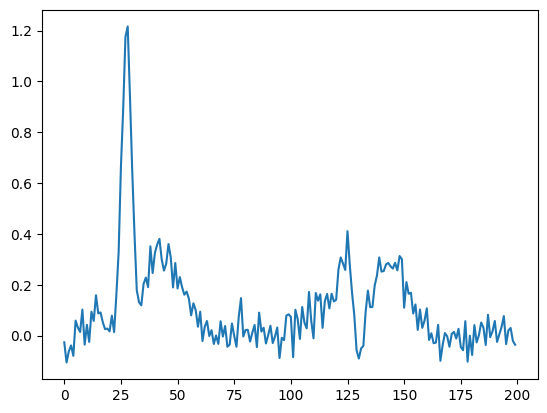

In [27]:
plt.plot(s[200:400])

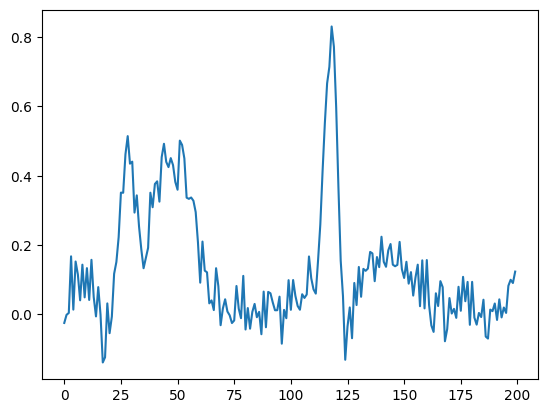

In [25]:
plt.plot(s[200:400])